# M2 forces vs. M2 Closed-loop breakout test

## Readme

This notebook analyzes the evolutions of the measured forces for the tangent and axial actuators during a break-out of the M2 closed-loop during the ramp-up of the TMA slewing speed test campaing. 
Modify the EFD time windows to run again the script on different datasets.

Enter manually the timestamp of the testing window. 

## Import Modules

This notebook needs to setup the **ts_m2com** and **ts_aos_utilsts** under the **notebooks/.user_setups**, which depends on the **ts_tcpip**.
You also need to have **ts_mtm2** under the **WORK/** directory to read the confiugration files to do the analysis.

In [1]:
%matplotlib inline
# %matplotlib widget  
import matplotlib.pyplot as plt
import math
from pathlib import Path
import numpy as np
from sklearn.linear_model import LinearRegression
from astropy.time import Time
import pandas as pd
import lsst_efd_client

from lsst.ts.m2com.mock import MockModel
from lsst.ts.m2com import MockControlClosedLoop
import tabulate 
from lsst.ts.aos.utils import DiagnosticsM2, EfdName

## TMA slewing intervals

In [2]:
# M2 CL break-out intervals - TMA Slewing intervals

slew_intervals = {
    0: [
        # 1% el 1% az
        Time("2024-11-06T08:42:00",scale="utc", format="isot"),
        Time("2024-11-06T08:45:18",scale="utc", format="isot"),
    ],
}


## Set title plots

In [3]:
# create title slewing speed
title = "TMA (1%,1%) max speed, M2 with glass"
location ="best"

## Functions declaration

In [4]:
async def query_data(
    diagnostics_m2: DiagnosticsM2,
    # control_closed_loop: MockControlClosedLoop,
    time_start: Time,
    time_end: Time,
) -> None:
    """
    Query the data.

    # functions declaration can be found here:
    # https://github.com/lsst-ts/ts_aos_utils/blob/feature/m2power/python/lsst/ts/aos/utils/diagnostics_m2.py
    Parameters
    ----------
    diagnostics_m2 : `lsst.ts.aos.utils.DiagnosticsM2`
        M2 diagnostics instance.
    control_closed_loop : `lsst.ts.m2.com.MockControlClosedLoop`
        Mock control closed loop instance.
    time_start : `astropy.time.core.Time`
        Start time.
    time_end : `astropy.time.core.Time`
        End time.
    """

    # Get the x, y position of actuators
    # xy_actuators = diagnostics_m2.get_xy_actuators(control_closed_loop)

    # Query data
    data_ims, time_operation_ims = await diagnostics_m2.get_data_position(
        "positionIMS", time_start, time_end
    )

    data_collected_axial, data_collected_tangent = await diagnostics_m2.get_data_force(
        time_start, time_end
    )

    data_power_status, time_operation = await diagnostics_m2.get_data_power_status(
        time_start, time_end
    )

    data_inclinometer = await diagnostics_m2.get_data_zenith_angle(
        time_start, time_end
    )

    data_tangent_force_error = await diagnostics_m2.get_data_force_error_tangent(
       time_start, time_end
    )

    data_net_moment = await diagnostics_m2.get_data_net_moment(
       time_start, time_end
    )

    # return xy_actuators, data_ims, data_collected_axial, data_collected_tangent, data_power_status, data_inclinometer, data_net_moment
    return data_ims, data_collected_axial, data_collected_tangent, data_power_status, data_inclinometer, data_net_moment

In [5]:
def actuator_plot(
    diagnostics_m2,
    # control_closed_loop,
    actuators_groups,
    group,
    data_collected_tangent,
    full_stream,
    face,
    data_ims,
    merged_vectors,
    data_inclinometer,
    key,
    m2_cl_status_breakout,
    title,
):

    

    
    
    #************************************
    #
    #    Set UTC x axis metrics
    #
    #************************************


    # time stamp closed-loop breakout event
    
    t1 = m2_cl_status_breakout.index[0]
    print(t1)

    td = pd.Timedelta("0.05 sec")

    cl = np.where(abs(t1 -  merged_vectors.index) < td)

    t2 = merged_vectors.index[cl]

    time_ol_event = t2[0]
    
    print(time_ol_event)

    
    time_ol_event = m2_cl_status_breakout.index[0]
    asse = merged_vectors["measured0"]

    xx1 = [asse.index[0],time_ol_event, asse.index[-1]]
    xx2 = [asse.index[0], time_ol_event]
    
    tempo = xx1
    tempo2 = xx2
    
    tempo = pd.to_datetime(tempo, format='%Y-%m-%d %H:%M:%S.%f').strftime('%Y-%m-%d %H:%M')
    tempo2 = pd.to_datetime(tempo2, format='%Y-%m-%d %H:%M:%S.%f').strftime('%H:%M:%S')

    cl1 = pd.to_datetime(time_ol_event, format='%Y-%m-%d %H:%M:%S.%f').strftime('%Y-%m-%d %H:%M')
    cl2 = pd.to_datetime(time_ol_event, format='%Y-%m-%d %H:%M:%S.%f').strftime('%H:%M:%S')


    newx2 = [tempo2[0],cl2]
    newx1 = [tempo[0],cl1,tempo[-1]]


    



    #************************************
    #
    #    PLOT measured tangent forces
    #
    #************************************

    font = {
        "family": "serif",
        "color": "black",
        "weight": "normal",
        "size": 10,
    }

    hatF = "$\overline{F}), N$"

    
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.9, wspace=0.9)
    
    n = 6
    fig.suptitle(title)

    for idx in range(n):
        ax = fig.add_subplot(3, 2, idx + 1)
        ax.plot(merged_vectors[f"measured{idx}"],color="black")
        ax.set_xticks(xx2, newx2)
        ax.axhline(4893, color="orange", label="+CL Max F")
        ax.axhline(6227, color="red", label="+OL Max F")
        ax.axhline(-4893, color="orange")
        ax.axhline(-6227, color="red")
        ax.axvline(time_ol_event, label = 'CL breakout', color="black", linewidth = "0.5")

        num_act = actuators_groups[idx] + 1
        ax.set_title("A%i" % (idx + 1), fontdict=font)
        ax.set_ylabel("Meas. F, N", fontdict=font)


        if idx == 1:
            ax.set_ylim([-7000, 7000])
            ax.legend(loc="upper right", fontsize="8")
            
        elif idx == 2:
            ax.set_ylim([-7000, 7000])

        elif idx == 4:
            ax.set_ylim([-7000, 7000])
            ax.set_xlabel("UTC", fontdict=font)

        elif idx == 5:
            ax.set_ylim([-7000, 7000])
            ax.set_xlabel("UTC", fontdict=font)


    
    # ********************************************
    #
    #    ISM RBM
    #
    # ********************************************



    font = {
        "family": "serif",
        "color": "black",
        "weight": "normal",
        "size": 9,
    }

    fig = plt.figure(figsize=(10,8))

    ax1 = plt.subplot(231)
    ax1.plot(merged_vectors["x"])
    ax1.set_ylabel("IMS x, \u03BCm", fontdict=font)
    ax1.axvline(time_ol_event, label = 'CL breakout', color="black", linewidth = "0.5")
    ax1.set_xticks(xx2, newx2)
    ax1.legend(loc="best", fontsize="8")
    
    ax2 = plt.subplot(232)
    ax2.plot(merged_vectors["y"])
    ax2.set_ylabel("IMS y, \u03BCm", fontdict=font)
    ax2.axvline(time_ol_event, color="black", linewidth = "0.5")
    ax2.set_xticks(xx2, newx2)

    ax3 = plt.subplot(233)
    ax3.plot(merged_vectors["z"])
    ax3.set_ylabel("IMS z, \u03BCm", fontdict=font)
    ax3.axvline(time_ol_event, color="black", linewidth = "0.5")
    ax3.set_xticks(xx2, newx2)

    ax4 = plt.subplot(234)
    ax4.plot(merged_vectors["xRot"])
    ax4.set_ylabel("IMS xRot, arcsec", fontdict=font)
    ax4.set_xlabel("UTC", fontdict=font)
    ax4.axvline(time_ol_event, color="black", linewidth = "0.5")
    ax4.set_xticks(xx2, newx2)
 
    ax5 = plt.subplot(235)
    ax5.plot(merged_vectors["yRot"])
    ax5.set_ylabel("IMS yRot, arcsec", fontdict=font)
    ax5.set_xlabel("UTC", fontdict=font)
    ax5.axvline(time_ol_event, color="black", linewidth = "0.5")
    ax5.set_xticks(xx2, newx2)
 
    
    ax6 = plt.subplot(236)
    ax6.plot(merged_vectors["zRot"])
    ax6.set_ylabel("IMS zRot, arcsec", fontdict=font)
    ax6.set_xlabel("UTC", fontdict=font)
    ax6.axvline(time_ol_event, color="black", linewidth = "0.5")
    ax6.set_xticks(xx2, newx2)
    
    fig.suptitle(title)

    fig.tight_layout()



    


    # ********************************************
    #
    #    Sum & Weight force errors 
    #
    # ********************************************


    font = {
        "family": "serif",
        "color": "black",
        "weight": "normal",
        "size": 10,
    }


    fig = plt.figure()

    ax1 = plt.subplot(111)
    fig.suptitle(title)
    ax1.plot(merged_vectors["force0"],label="A1 $F_{error}$")
    ax1.plot(merged_vectors["force1"],label="A2 $F_{error}$")
    ax1.plot(merged_vectors["force2"],label="A3 $F_{error}$")
    ax1.plot(merged_vectors["force3"],label="A4 $F_{error}$")
    ax1.plot(merged_vectors["force4"],label="A5 $F_{error}$")
    ax1.plot(merged_vectors["force5"],label="A6 $F_{error}$")
    ax1.plot(merged_vectors["sum"],label="Sum $F_{error} < 1000N$")
    ax1.plot(merged_vectors["weight"],label="Weight $F_{error}$")

    ax1.axvline(time_ol_event, label = 'CL breakout', color="black", linewidth = "0.5")
    
    ax1.axhline(1000, linestyle = "dashed", color="red")
    ax1.axhline(-1000, linestyle = "dashed", color="red")
    ax1.axhline(2000, color="red")
    ax1.axhline(-2000, color="red")
    ax1.set_xticks(xx1,newx1)
    ax1.set_ylabel("Tangent force errors, N", fontdict=font)
    ax1.set_xlabel("UTC", fontdict=font)
    ax1.legend(loc="lower right", fontsize="8")
    ax1.set_title("TMA", fontdict=font)
   
 
    fig.tight_layout()

    


    font = {
        "family": "serif",
        "color": "black",
        "weight": "normal",
        "size": 10,
    }

    fig = plt.figure()

    fig.suptitle(title)
    ax1 = plt.subplot(111)
    lns1 = ax1.plot(merged_vectors["inclinometerProcessed"],label="Elevation", color = "black")
    ax1.set_ylabel("TMA Elevation, deg", fontdict=font)
    ax2 = ax1.twinx()
    lns3 = ax1.axvline(time_ol_event, label = 'CL breakout', color="black", linewidth = "0.5")
    lns2 = ax2.plot(merged_vectors["actualPosition"],label="Azimuth", color = "green");
    ax2.set_ylabel("TMA Azimuth, deg", fontdict=font)
    lns = lns1+lns2+[lns3]
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc = "center right")
    ax1.set_xticks(xx1,newx1)
    ax1.set_xlabel("UTC", fontdict=font)
    fig.tight_layout()

    

In [6]:
def actuator_plot_axial(
    diagnostics_m2,
    # control_closed_loop,
    actuators_groups,
    group,
    data_collected_axial,
    full_stream,
    face,
    data_ims,
    merged_vectors,
    data_inclinometer,
    key,
    m2_cl_status_breakout,
    title,
):


    #************************************
    #
    #    Set UTC x axis metrics
    #
    #************************************

    # time stamp closed-loop breakout event
    
    t1 = m2_cl_status_breakout.index[0]
    print(t1)

    td = pd.Timedelta("0.05 sec")

    cl = np.where(abs(t1 -  merged_vectors.index) < td)

    t2 = merged_vectors.index[cl]

    time_ol_event = t2[0]
    
    print(time_ol_event)

    
    time_ol_event = m2_cl_status_breakout.index[0]
    asse = merged_vectors["measured0"]

    xx1 = [asse.index[0],time_ol_event, asse.index[-1]]
    xx2 = [asse.index[0], time_ol_event]
    
    tempo = xx1
    tempo2 = xx2
    
    tempo = pd.to_datetime(tempo, format='%Y-%m-%d %H:%M:%S.%f').strftime('%Y-%m-%d %H:%M')
    tempo2 = pd.to_datetime(tempo2, format='%Y-%m-%d %H:%M:%S.%f').strftime('%H:%M:%S')

    cl1 = pd.to_datetime(time_ol_event, format='%Y-%m-%d %H:%M:%S.%f').strftime('%Y-%m-%d %H:%M')
    cl2 = pd.to_datetime(time_ol_event, format='%Y-%m-%d %H:%M:%S.%f').strftime('%H:%M:%S')


    newx2 = [tempo2[0],cl2]
    newx1 = [tempo[0],cl1,tempo[-1]]


    

    #************************************
    #
    #    PLOT measured axial forces
    #
    #************************************

    font = {
        "family": "serif",
        "color": "black",
        "weight": "normal",
        "size": 10,
    }

    hatF = "$\overline{F}), N$"
    
    fig = plt.figure()
    
    n = 72
    fig.suptitle(title)
    ax = fig.add_subplot(1, 1, 1)
    
    for idx in range(n):
        ax.plot(merged_vectors[f"measured{idx}"])
    ax.set_xticks(xx1,newx1)
    ax.axhline(444, color="orange", label="+CL Max F")
    ax.axhline(666, color="red", label="+OL Max F")
    ax.axhline(-444, color="orange")
    ax.axhline(-666, color="red") 
    ax.axvline(time_ol_event, label = 'CL breakout', color="black", linewidth = "0.5")
    ax.set_ylabel("Measured axial forces, N", fontdict=font)
    ax.set_xlabel("UTC", fontdict=font)
    ax.legend(loc="upper right", fontsize="8")

    

In [7]:
def add_force_error(data: pd.DataFrame) -> pd.DataFrame:
 

    df = data.copy()
    cols = ["force0", "force1", "force2", "force3", "force4", "force5", "weight", "sum"]


    for i, row in enumerate(data.iterrows()):
        if abs(row[1]["inclinometerRaw"]) > 360:
            c = 1
            searching = True
            while searching:
                eval_angle = data.loc[data.index[i - c], "inclinometerRaw"]
                if abs(eval_angle) < 360:
                    angle = eval_angle
                    searching = False
                else:
                    c += 1
        else:
            angle = row[1]["inclinometerRaw"]

        mock = MockModel()
        angle = mock.control_open_loop.correct_inclinometer_angle(angle)
        mock.control_open_loop.inclinometer_angle = angle

        tangent_force_error = mock._calculate_force_error_tangent(
            np.array(
                [
                    row[1]["measured0"],
                    row[1]["measured1"],
                    row[1]["measured2"],
                    row[1]["measured3"],
                    row[1]["measured4"],
                    row[1]["measured5"],
                ]
            )
        )

        df.loc[row[0], cols[:-2]] = tangent_force_error["force"]
        df.loc[row[0], cols[-2]] = tangent_force_error["weight"]
        df.loc[row[0], cols[-1]] = tangent_force_error["sum"]

    return df

In [8]:
async def get_merge_query(
    efd_client: lsst_efd_client.EfdClient,
    topics: list,
    start_time: Time,
    end_time: Time,
    tolerance=None,
    direction: str = None,
):
    query_df = list()
    calculate_force_error = False
    for topic in topics:
        topic_fields = await efd_client.get_fields(topic)
        query = efd_client.build_time_range_query(
            topic, topic_fields, start_time, end_time
        )
        data_query = await efd_client.influx_client.query(query)
        if len(data_query) == 0 and topic == "lsst.sal.MTM2.forceErrorTangent":
            print(f"{topic} is not present, try to calculate it.")
            calculate_force_error = True
        elif len(data_query) == 0:
            print(f"{topic} is not present.")
        else:
            query_df.append(data_query)
    if len(query_df) == 1:
        return query_df[0]
    elif len(query_df) == 0:
        print("No Dataframe retrieve")
        return query_df
    query_df.sort(key=lambda el: len(el), reverse=True)
    merge_df = query_df[0].copy()
    for i, df in enumerate(query_df[1:]):
        col_left = topics[i].split(".")[-1]
        col_right = topics[i + 1].split(".")[-1]
        if tolerance is None and direction is None:
            merge_df = lsst_efd_client.rendezvous_dataframes(
                merge_df,
                df,
                direction="nearest",
                suffixes=[f"_{col_left}", f"_{col_right}"],
            )
        elif tolerance is None and direction is not None:
            merge_df = lsst_efd_client.rendezvous_dataframes(
                merge_df,
                df,
                direction=direction,
                suffixes=[f"_{col_left}", f"_{col_right}"],
            )
        elif tolerance is not None and direction is None:
            merge_df = lsst_efd_client.rendezvous_dataframes(
                merge_df,
                df,
                direction="nearest",
                tolerance=tolerance,
                suffixes=[f"_{col_left}", f"_{col_right}"],
            )
        else:
            merge_df = lsst_efd_client.rendezvous_dataframes(
                merge_df,
                df,
                direction=direction,
                tolerance=tolerance,
                suffixes=[f"_{col_left}", f"_{col_right}"],
            )
    if calculate_force_error:
        merge_df = add_force_error(merge_df)
    return merge_df


In [9]:
def spot_cl_breakout_event(
    merged_vectors,
    key,
):
    
    
    # find M2 closed loop break-out time

    
    useful_index = []
    
    
    # find M2 closed loop break-out time 
    #if m2_cl_status.shape[0] == 0:
     #   continue

    for i, status in enumerate(m2_cl_status["mode"]):
        print(status)
        # find open loop event = 3
        if (status == 3):
            useful_index.append(i)

    if len(useful_index) != 0:
       print("Timestamp M2 CL breakout:")
       print(useful_index[0], m2_cl_status.index[useful_index[0]])

    m2_cl_status_breakout = m2_cl_status.index[useful_index[0]]
    
    return useful_index, m2_cl_status_breakout

## Instantiate the MockControlClosedLoop

In [10]:
# config_path = Path.home() / "WORK" / "ts_mtm2" / "config" / "parameter_files"
# filepath_cell_geom = Path.home() / "WORK" / "ts_mtm2" / "config" / "cellGeom.json"

In [11]:
# control_closed_loop = MockControlClosedLoop()
# control_closed_loop.load_file_cell_geometry(filepath_cell_geom)

## Instantiate the DiagnosticsM2 Class

Notice that the UTC time is used when doing the query.

In [12]:
diagnostics_m2 = DiagnosticsM2(efd_name=EfdName.Usdf)

# Instatiate EFD client

In [13]:
efd_client = lsst_efd_client.EfdClient(efd_name="usdf_efd")

## Tangent actuators

In [14]:
actuators_groups = np.array([72, 73, 74, 75, 76, 77])

/home/r/rosignol/WORK/ts_aos_utils/python/lsst/ts/aos/utils/diagnostics_default.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.array(timestamps.subtract(timestamps[0]))
/home/r/rosignol/WORK/ts_aos_utils/python/lsst/ts/aos/utils/diagnostics_default.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.array(timestamps.subtract(timestamps[0]))
/home/r/rosignol/WORK/ts_aos_utils/python/lsst/ts/aos/utils/diagnostics_default.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior

2024-11-06 08:43:53.741260+00:00
2024-11-06 08:43:53.739389+00:00


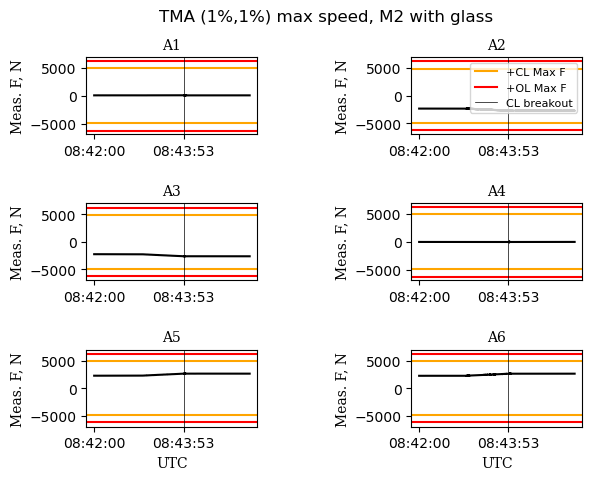

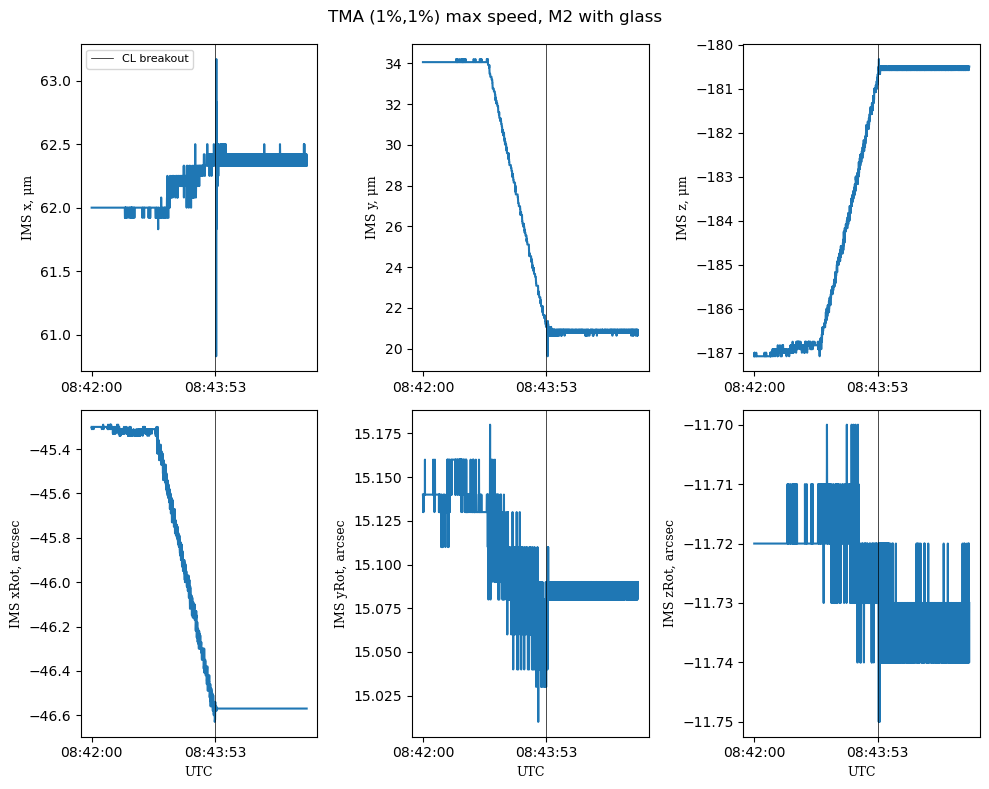

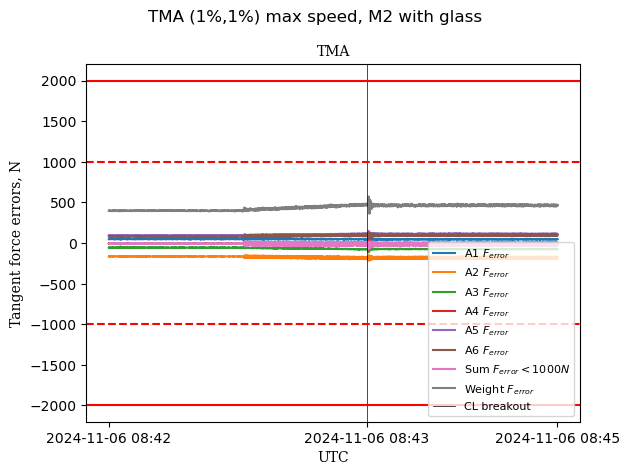

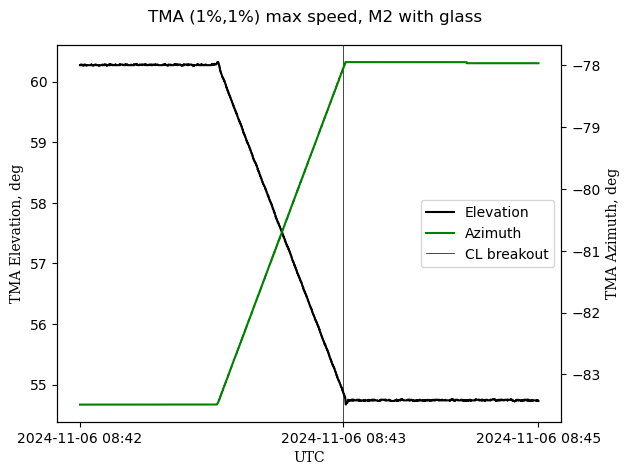

In [15]:

# Plots for tangent actuators

for key, val in slew_intervals.items():
    time_start = val[0]
    time_end = val[1]


    (
        # xy_actuators,
        data_ims, 
        data_collected_axial, 
        data_collected_tangent, 
        data_power_status, 
        data_inclinometer,
        data_net_moment,
    ) = await query_data(diagnostics_m2, time_start, time_end) # await query_data(diagnostics_m2, control_closed_loop, time_start, time_end)

    

    merged_vectors = await get_merge_query(
    efd_client,
    [
    "lsst.sal.MTM2.tangentEncoderPositions",  
    "lsst.sal.MTM2.tangentForce",
    "lsst.sal.MTM2.forceErrorTangent",
    "lsst.sal.MTM2.positionIMS",
    "lsst.sal.MTM2.displacementSensors",
    "lsst.sal.MTM2.zenithAngle",
    "lsst.sal.MTM2.forceBalance",
    "lsst.sal.MTMount.azimuth",
    ],
        time_start,
        time_end,
        
    )

    
    m2_cl_status_breakout = await efd_client.select_time_series(
        "lsst.sal.MTM2.logevent_closedLoopControlMode",
        fields=["mode"],
        start=time_start,
        end=time_end) 



    full_stream = len(data_collected_tangent["measured"])
    
    actuator_plot(
        diagnostics_m2,
        # control_closed_loop,
        actuators_groups,
        key,
        data_collected_tangent,
        full_stream,
        "down",
        data_ims,
        merged_vectors,
        data_inclinometer,
        key,
        m2_cl_status_breakout,
        title,
    )


/home/r/rosignol/WORK/ts_aos_utils/python/lsst/ts/aos/utils/diagnostics_default.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.array(timestamps.subtract(timestamps[0]))
/home/r/rosignol/WORK/ts_aos_utils/python/lsst/ts/aos/utils/diagnostics_default.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.array(timestamps.subtract(timestamps[0]))
/home/r/rosignol/WORK/ts_aos_utils/python/lsst/ts/aos/utils/diagnostics_default.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior

2024-11-06 08:43:53.741260+00:00
2024-11-06 08:43:53.723759+00:00


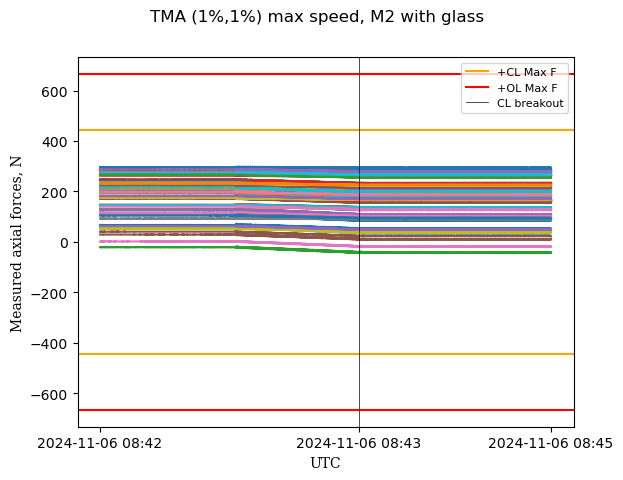

In [16]:

# Plots for axial actuators

for key, val in slew_intervals.items():
    time_start = val[0]
    time_end = val[1]


    (
        # xy_actuators,
        data_ims, 
        data_collected_axial, 
        data_collected_tangent, 
        data_power_status, 
        data_inclinometer,
        data_net_moment,
    ) = await query_data(diagnostics_m2, time_start, time_end) # await query_data(diagnostics_m2, control_closed_loop, time_start, time_end)

    

    merged_vectors = await get_merge_query(
    efd_client,
    [
    "lsst.sal.MTM2.axialEncoderPositions",  
    "lsst.sal.MTM2.axialForce",
    "lsst.sal.MTM2.forceErrorTangent",
    "lsst.sal.MTM2.zenithAngle",
    "lsst.sal.MTM2.forceBalance",
    "lsst.sal.MTMount.azimuth",
    ],
        time_start,
        time_end,
        
    )

    m2_cl_status_breakout = await efd_client.select_time_series(
        "lsst.sal.MTM2.logevent_closedLoopControlMode",
        fields=["mode"],
        start=time_start,
        end=time_end)

    full_stream = len(data_collected_axial["measured"])
    
    actuator_plot_axial(
        diagnostics_m2,
        # control_closed_loop,
        actuators_groups,
        key,
        data_collected_axial,
        full_stream,
        "down",
        data_ims,
        merged_vectors,
        data_inclinometer,
        key,
        m2_cl_status_breakout,
        title,
    )

